<a href="https://colab.research.google.com/github/mehak2323/GarbageClassification/blob/main/GarbageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setting up environment**

#### Setting up environment by importing saved Garbage classification data from Google Drive and unzipping it.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive
 
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

!kaggle datasets download -d asdasdasasdas/garbage-classification

/content/gdrive/My Drive/Kaggle
 99% 81.0M/82.0M [00:00<00:00, 102MB/s] 
100% 82.0M/82.0M [00:00<00:00, 112MB/s]


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: Garbage classification/Garbage classification/cardboard/cardboard152.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard153.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard154.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard155.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard156.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard157.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard158.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard159.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard16.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard160.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/c

#### Importing libraries and packages.

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing import image
import glob, os, random

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

#### Displaying random images from the image data list using plot.

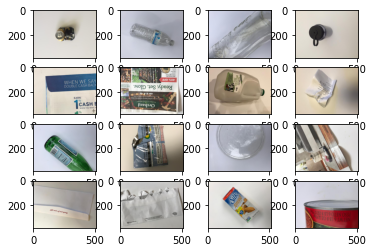

In [ ]:
data_path = '/content/gdrive/MyDrive/Kaggle/Garbage classification/Garbage classification'
img_list = glob.glob(os.path.join(data_path, '*/*.jpg'))
 
for i, img_path in enumerate(random.sample(img_list, 16)):
    img = image.load_img(img_path)
    img = image.img_to_array(img, dtype=np.uint8)
 
    plt.subplot(4, 4, i+1)
    plt.imshow(img)

# **Image Data Processing**

#### Dividing the images into train, validation and test sets.

In [ ]:
def list_dataset():
    for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/kaggle/'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

# Add class name prefix to each path based on class name include in filename
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

def class_id_to_label(id):
    label_map = {1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}
    return label_map[id]
    
IMAGES_DIR = '/content/gdrive/MyDrive/Kaggle/Garbage classification/Garbage classification'
    
train_file = '/content/gdrive/MyDrive/Kaggle/one-indexed-files-notrash_train.txt'
val_file   = '/content/gdrive/MyDrive/Kaggle/one-indexed-files-notrash_val.txt'
test_file  = '/content/gdrive/MyDrive/Kaggle/one-indexed-files-notrash_test.txt'

df_train = pd.read_csv(train_file, sep=' ', header=None, names=['rel_path', 'label'])
df_valid = pd.read_csv(val_file,   sep=' ', header=None, names=['rel_path', 'label'])
df_test  = pd.read_csv(val_file,   sep=' ', header=None, names=['rel_path', 'label'])

df_train = add_class_name_prefix(df_train, 'rel_path')
df_valid = add_class_name_prefix(df_valid, 'rel_path')
df_test  = add_class_name_prefix(df_test,  'rel_path')

df_train['label'] = df_train['label'].apply(class_id_to_label)
df_valid['label'] = df_valid['label'].apply(class_id_to_label)
df_test['label']  = df_test['label'].apply(class_id_to_label)

print(f'Found {len(df_train)} training, {len(df_valid)} validation and {len(df_test)} test samples.')

df_train.head()

Found 1768 training, 328 validation and 328 test samples.


,rel_path,label
0,cardboard/cardboard202.jpg,cardboard
1,paper/paper472.jpg,paper
2,paper/paper522.jpg,paper
3,glass/glass189.jpg,glass
4,glass/glass325.jpg,glass


#### Generating image data using ImageDataGenerator and categorize training, validation and testing data.

In [ ]:
datagen = ImageDataGenerator()

datagen_train = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=7,
)

datagen_valid = datagen.flow_from_dataframe(
    dataframe=df_valid,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=7,
)

test_generator = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=7
)

Found 1768 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.


# **Building model** 

#### Building a ResNet50 model with pretrained Imagenet weights with an averagePooling and Dense layer with softmax activation at the end.

In [ ]:
def build_model(num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False)

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False
        
    return model

model = build_model(num_classes=6)

model.compile(optimizer='Adam',
            loss='categorical_crossentropy',
            metrics=[tf.keras.metrics.categorical_accuracy])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

#### Plotting the model architecture using plot_model function.

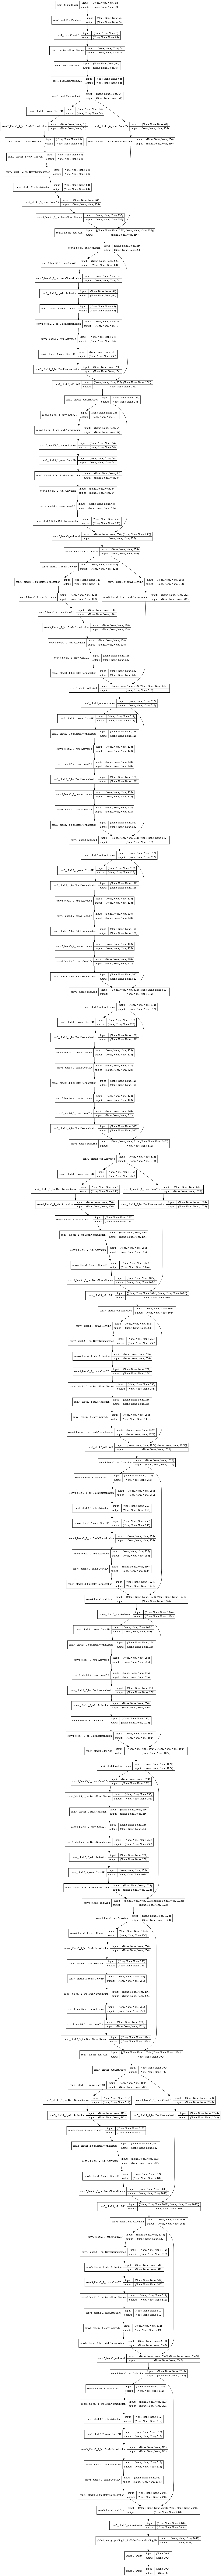

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# **Training the model**

#### Training the model using fit_generator function with early stopping if accuracy doesn't improve.

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit_generator(
    generator=datagen_train,
    validation_data=datagen_valid,
    epochs=10,
    validation_freq=1,
    callbacks=[early_stop]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
56/56 [==============================] - 422s 7s/step - loss: 1.5550 - categorical_accuracy: 0.5901 - val_loss: 0.5287 - val_categorical_accuracy: 0.8110
Epoch 2/10
56/56 [==============================] - 421s 8s/step - loss: 0.3530 - categorical_accuracy: 0.8686 - val_loss: 0.4850 - val_categorical_accuracy: 0.8384
Epoch 3/10
56/56 [==============================] - 416s 7s/step - loss: 0.2428 - categorical_accuracy: 0.9199 - val_loss: 0.4763 - val_categorical_accuracy: 0.8323
Epoch 4/10
56/56 [==============================] - 416s 7s/step - loss: 0.1498 - categorical_accuracy: 0.9540 - val_loss: 0.3058 - val_categorical_accuracy: 0.8902
Epoch 5/10
56/56 [==============================] - 423s 8s/step - loss: 0.0612 - categorical_accuracy: 0.9840 - val_loss: 0.3585 - val_categorical_accuracy: 0.8750
Epoch 6/10
56/56 [==============================] - 420s 8s/step - loss: 0.0625 - categorical_accuracy: 0.9841 - val_loss: 0.3150 - val_categorical_accuracy: 0.8811
Epoch 7/10

#### Plotting loss, val_loss and acc, val_acc based on epochs.

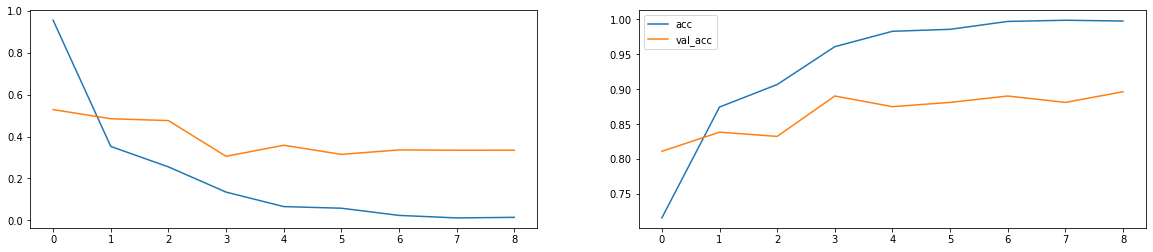

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))

axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='val_loss')

axs[1].plot(history.history['categorical_accuracy'], label='acc')
axs[1].plot(history.history['val_categorical_accuracy'], label='val_acc')

plt.legend();
plt.show();

# **Testing Model**

#### Testing the model on test images.

In [ ]:
# verify the performance of the model
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy :', accuracy)
print('Test loss:', loss)

328/328 [==============================] - 77s 235ms/step - loss: 0.3058 - categorical_accuracy: 0.8902
Test accuracy : 0.8902438879013062
Test loss: 0.30577754974365234


#### Plotting the confusion matrix to see number of correctly classified images.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix


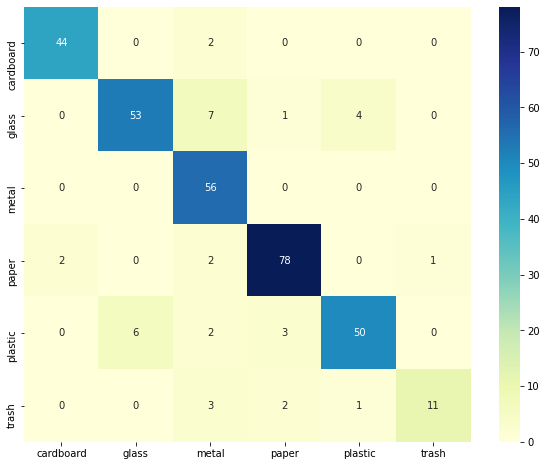

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm=confusion_matrix(test_generator.classes, y_pred)

waste_types=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")